# **CZ4071 Reconstructing the Network**
**Author: Rajeswari Bose**

### **0. Import dependencies**

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import requests
import random
import pickle

### **1. Read input file**

In [6]:
df = pd.read_csv("./Input/ProcessedNetworkDataFrame.csv")
df

,author_pid,coauthor_pid,year,title,author_name,coauthor_name
0,75/9436,163/0545,2021,Decomposed Bounded Floats for Fast Compression...,Aaron J. Elmore,John Paparrizos
1,75/9436,163/0545,2021,VergeDB: A Database for IoT Analytics on Edge ...,Aaron J. Elmore,John Paparrizos
2,75/9436,f/MJFranklin,2021,VergeDB: A Database for IoT Analytics on Edge ...,Aaron J. Elmore,Michael J. Franklin
3,75/9436,147/1189,2021,VergeDB: A Database for IoT Analytics on Edge ...,Aaron J. Elmore,Sanjay Krishnan
4,75/9436,117/3757,2021,Version Reconciliation for Collaborative Datab...,Aaron J. Elmore,Zechao Shang
...,...,...,...,...,...,...
31025,189/2405,20/3716,2019,Balance-Aware Distributed String Similarity-Ba...,Zeyuan Shang,Zhifeng Bao
31026,189/2405,20/3716,2018,DITA: Distributed In-Memory Trajectory Analytics.,Zeyuan Shang,Zhifeng Bao
31027,189/2405,20/3716,2018,DITA: A Distributed In-Memory Trajectory Analy...,Zeyuan Shang,Zhifeng Bao
31028,189/2405,20/3716,2017,Dima: A Distributed In-Memory Similarity-Based...,Zeyuan Shang,Zhifeng Bao


### **2. Prepare graph data**

In [7]:
author_pid = df["author_pid"].to_list()
coauthor_pid = df["coauthor_pid"].to_list()
collaborations = list(zip(author_pid, coauthor_pid))

In [8]:
with open('saved_attrs.pkl', 'rb') as f:
                attrs = pickle.load(f)

### **3. Original Graph**

In [38]:
#original collaboration network
G = nx.Graph()
G.add_edges_from(collaborations)

In [39]:
nx.set_node_attributes(G,attrs)

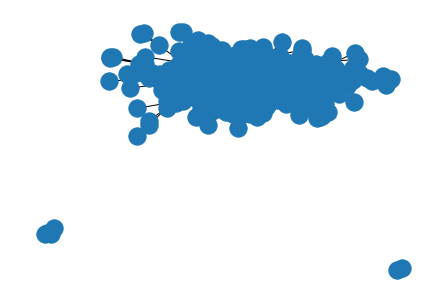

In [40]:
nx.draw(G)

In [41]:
print("Number of isolates: ", nx.number_of_isolates(G))
print("Number of connected components: ", nx.number_connected_components(G))
for C in (G.subgraph(c).copy() for c in sorted(nx.connected_components(G), key=len)):
  lcc = C
print("Size of giant component: ",nx.number_of_nodes(lcc))
print("Average Degree: ",nx.number_of_edges(G) / nx.number_of_nodes(G))

Number of isolates:  0
Number of connected components:  3
Size of giant component:  983
Average Degree:  6.518705763397371


### **4. Reconstructing Graph**

Function to calculate the diversity of a connected component

In [42]:
def calculate_diversity(connected_component):
  num_nodes=len(connected_component)
  countries=[]
  institutes=[]
  expertise=[]
  for node in connected_component:
    countries.append(G.nodes[node]['country'])
    institutes.append(G.nodes[node]['institute'])
    expertise.append(G.nodes[node]['expertise'])
  diversity=(len(set(countries))/num_nodes)*(len(set(institutes))/num_nodes)*(len(set(expertise))/num_nodes)
  return diversity

Removing those bridges which do not decrease/retain diversity

In [43]:
bridges=nx.bridges(G)
#removing bridges
for bridge in bridges:
  #calculating data of connected component
  cc_diversity=calculate_diversity(nx.node_connected_component(G, bridge[0]))
  cc_nodes=len(nx.node_connected_component(G, bridge[0]))
  G.remove_edge(bridge[0],bridge[1])
  #new diversity is weighted sum of new cc diversities
  cc_new_diversity=(len(nx.node_connected_component(G, bridge[0]))/cc_nodes)*calculate_diversity(nx.node_connected_component(G, bridge[0]))+(len(nx.node_connected_component(G, bridge[0]))/cc_nodes)*calculate_diversity(nx.node_connected_component(G, bridge[1]))
  #don't remove bridge if results in less diversity
  if (cc_diversity>cc_new_diversity):
    G.add_edge(bridge[0],bridge[1]) #TODO: add back attributes like country, expertise, and institution (not sure if it is removed after deleting edge)

In [44]:
#setting kmax=<k>
kmax=nx.number_of_edges(G) / nx.number_of_nodes(G)
print("Kmax= ",kmax)

Kmax=  6.437815975733064


Removing nodes such that the degree is not greater than kmax

In [45]:

#reducing degree of each node below kmax
for node in G:
  #only reducing if greater than kmax
  if(G.degree[node]>kmax):
    #removing edges in the following priority till degree is not greater than kmax 1) both nodes have the same country, institution, or expertise 2) decreasing order of other node's degree
    edges=G.edges(node)
    neighbours=[]
    for edge in edges:
      neighbours.append(edge[1])
    neighbour_degrees=[]
    zero_diff=[]
    one_diff=[]
    two_diff=[]
    neighbour_index=0
    for neighbour in neighbours:
      #get degrees of each neighbour
      neighbour_degrees.append(G.degree(neighbour))
      #get difference in attributes from node (range:0-3)
      neighbour_difference=0
      if(G.nodes[neighbour]['institute']!=G.nodes[node]['institute']):
        neighbour_difference+=1
      if(G.nodes[neighbour]['country']!=G.nodes[node]['country']):
        neighbour_difference+=1
      if(G.nodes[neighbour]['expertise']!=G.nodes[node]['expertise']):
        neighbour_difference+=1
      if neighbour_difference==0:
        zero_diff.append(neighbour_index)
      elif neighbour_difference==1:
        one_diff.append(neighbour_index)
      elif neighbour_difference==2:
        two_diff.append(neighbour_index)
      else:
        two_diff.append(neighbour_index)
      neighbour_index+=1
    sorted_degree_indexes=sorted(range(len(neighbour_degrees)), key=lambda k: neighbour_degrees[k])
    #removing: neighbours with 0 difference from node
    for index in zero_diff:
      G.remove_edge(node,neighbours[index])
      sorted_degree_indexes.remove(index)
    if G.degree(node)<=kmax:
      continue
    #removing: neighbours with 1 difference from node
    for index in one_diff:
      G.remove_edge(node,neighbours[index])
      sorted_degree_indexes.remove(index)
    if G.degree(node)<=kmax:
      continue
    #removing: neighbours with 2 differences from node
    for index in two_diff:
      G.remove_edge(node,neighbours[index])
      sorted_degree_indexes.remove(index)
    if G.degree(node)<=kmax:
      continue
    #removing nodes by highest degree till less than kmax
    while G.degree(node)>kmax:
      G.remove_edge(node,neighbours[sorted_degree_indexes[-1]])
      sorted_degree_indexes.pop()

### **5. Reconstructed Graph**

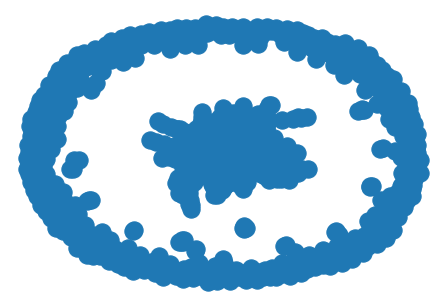

In [46]:
nx.draw(G)

In [47]:
print("Number of isolates: ", nx.number_of_isolates(G))
print("Number of connected components: ", nx.number_connected_components(G))
for C in (G.subgraph(c).copy() for c in sorted(nx.connected_components(G), key=len)):
  lcc = C
print("Size of giant component: ",nx.number_of_nodes(lcc))
print("kmax value: ",kmax)
print("Average Degree: ",nx.number_of_edges(G) / nx.number_of_nodes(G))

Number of isolates:  424
Number of connected components:  448
Size of giant component:  505
kmax value:  6.437815975733064
Average Degree:  0.7391304347826086
